In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, random_split, DataLoader

from torchvision import datasets, transforms, models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.utils import save_image

from torchsummary import summary

import spacy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import time
import math
from PIL import Image
import glob
from IPython.display import display

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
torch.manual_seed(0)
np.random.seed(0)

In [4]:
BATCH_SIZE = 64
LR = 5e-5
NUM_EPOCHES = 25

### Data Pre-processing

In [5]:
mean, std = (0.5,), (0.5,)

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean, std)
                              ])

In [6]:
trainset = datasets.MNIST('../data/MNIST/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

testset = datasets.MNIST('../data/MNIST/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw



### Model

In [7]:
pip install transformer-implementations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
from transformer_package.models import ViT

image_size = 28
channel_size = 1
patch_size = 7
embed_size = 512
num_heads = 8
classes = 10
num_layers = 3
hidden_size = 256
dropout = 0.2

model = ViT(image_size, channel_size, patch_size, embed_size, num_heads, classes, num_layers, hidden_size, dropout=dropout).to(device)
model

ViT(
  (dropout_layer): Dropout(p=0.2, inplace=False)
  (embeddings): Linear(in_features=49, out_features=512, bias=True)
  (encoders): ModuleList(
    (0): VisionEncoder(
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (attention): MultiHeadAttention(
        (dropout_layer): Dropout(p=0.2, inplace=False)
        (Q): Linear(in_features=512, out_features=512, bias=True)
        (K): Linear(in_features=512, out_features=512, bias=True)
        (V): Linear(in_features=512, out_features=512, bias=True)
        (linear): Linear(in_features=512, out_features=512, bias=True)
      )
      (mlp): Sequential(
        (0): Linear(in_features=512, out_features=2048, bias=True)
        (1): GELU(approximate=none)
        (2): Dropout(p=0.2, inplace=False)
        (3): Linear(in_features=2048, out_features=512, bias=True)
        (4): Dropout(p=0.2, inplace=False)
      )
    )
    (1): VisionEncoder(


In [9]:
for img, label in trainloader:
    img = img.to(device)
    label = label.to(device)
    
    print("Input Image Dimensions: {}".format(img.size()))
    print("Label Dimensions: {}".format(label.size()))
    print("-"*100)
    
    out = model(img)
    
    print("Output Dimensions: {}".format(out.size()))
    break

Input Image Dimensions: torch.Size([64, 1, 28, 28])
Label Dimensions: torch.Size([64])
----------------------------------------------------------------------------------------------------
Output Dimensions: torch.Size([64, 10])


In [10]:
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=LR)

In [11]:
loss_hist = {}
loss_hist["train accuracy"] = []
loss_hist["train loss"] = []

for epoch in range(1, NUM_EPOCHES+1):
    model.train()
    
    epoch_train_loss = 0
        
    y_true_train = []
    y_pred_train = []
        
    for batch_idx, (img, labels) in enumerate(trainloader):
        img = img.to(device)
        labels = labels.to(device)
        
        preds = model(img)
        
        loss = criterion(preds, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        y_pred_train.extend(preds.detach().argmax(dim=-1).tolist())
        y_true_train.extend(labels.detach().tolist())
            
        epoch_train_loss += loss.item()
    
    loss_hist["train loss"].append(epoch_train_loss)
    
    total_correct = len([True for x, y in zip(y_pred_train, y_true_train) if x==y])
    total = len(y_pred_train)
    accuracy = total_correct * 100 / total
    
    loss_hist["train accuracy"].append(accuracy)
    
    print("-------------------------------------------------")
    print("Epoch: {} Train mean loss: {:.8f}".format(epoch, epoch_train_loss))
    print("       Train Accuracy%: ", accuracy, "==", total_correct, "/", total)
    print("-------------------------------------------------")

-------------------------------------------------
Epoch: 1 Train mean loss: 645.86589458
       Train Accuracy%:  76.97666666666667 == 46186 / 60000
-------------------------------------------------
-------------------------------------------------
Epoch: 2 Train mean loss: 223.12399724
       Train Accuracy%:  92.60333333333334 == 55562 / 60000
-------------------------------------------------
-------------------------------------------------
Epoch: 3 Train mean loss: 171.57279806
       Train Accuracy%:  94.22 == 56532 / 60000
-------------------------------------------------
-------------------------------------------------
Epoch: 4 Train mean loss: 146.85726491
       Train Accuracy%:  95.01666666666667 == 57010 / 60000
-------------------------------------------------
-------------------------------------------------
Epoch: 5 Train mean loss: 124.63873019
       Train Accuracy%:  95.75833333333334 == 57455 / 60000
-------------------------------------------------
-----------------

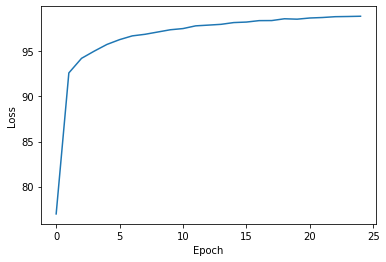

In [12]:
plt.plot(loss_hist["train accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

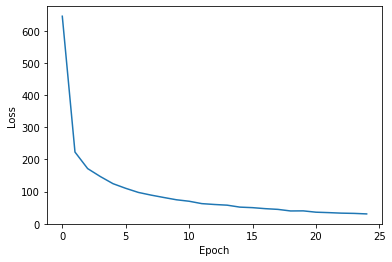

In [13]:
plt.plot(loss_hist["train loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [14]:
with torch.no_grad():
    model.eval()
    
    y_true_test = []
    y_pred_test = []
    
    for batch_idx, (img, labels) in enumerate(testloader):
        img = img.to(device)
        label = label.to(device)
    
        preds = model(img)
        
        y_pred_test.extend(preds.detach().argmax(dim=-1).tolist())
        y_true_test.extend(labels.detach().tolist())
        
    total_correct = len([True for x, y in zip(y_pred_test, y_true_test) if x==y])
    total = len(y_pred_test)
    accuracy = total_correct * 100 / total
    
    print("Test Accuracy: ", accuracy,"%", "==", total_correct, "/", total)

Test Accuracy:  98.41 % == 9841 / 10000
